## Peter and the Wolf: Reinforcement Learning Primer
Apply RL to a problem of path finding. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

### The Environment
For simplicity, let's consider Peter's world to be a square board of size width x height. 
Each cell in this board can either be:

- ground, on which Peter and other creatures can walk
- water, on which you obviously cannot walk
- a tree or grass - a place where you cat take some rest
- an apple, which represents something Peter would be glad to find in order to feed himself
- a wolf, which is dangerous and should be avoided

In [2]:
from rlboard import *

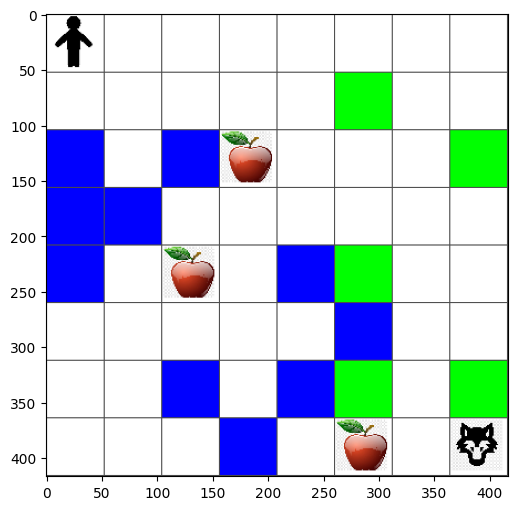

In [3]:
width, height = 8, 8
m = Board(width, height)
m.randomize(seed=13)
m.plot()

### Actions and Plocy


The strategy of our agent is defined by a so-called policy. Let's consider the simplest policy called random walk.

In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

### Random walk

In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m, policy, start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # Success
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # Eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human, a)
            if m.is_valid(new_pos) and m.at(new_pos) != Board.Cell.water:
                m.move(a) # do the actual move
                break
        n += 1

walk(m, random_policy)

18

run random walk experiment several times and see the average number of steps taken:

In [6]:
def print_statistics(policy):
    s, w, n = 0, 0, 0
    for _ in range(100):
        z = walk(m, policy)
        if z<0:
            w += 1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


### Reward Function

In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m, pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x == Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x == Board.Cell.apple:    
        return goal_reward
    return move_reward

### Q-Learning
represent the Q-Table using a numpy array with shape width x height x len(actions)

In [8]:
Q = np.ones((width, height, len(actions)), dtype=np.float32)*1.0/len(actions)

visualize the table on the board:

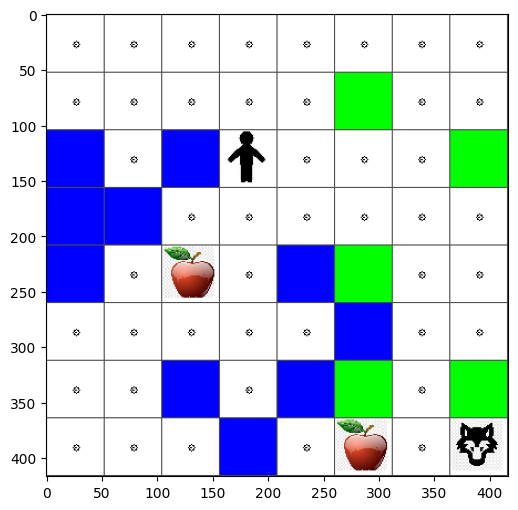

In [9]:
m.plot(Q)

pseudo-code for our learning algorithm:

- Initialize Q-Table Q with equal numbers for all states and actions
- Set learning rate α ← 1
- Repeat simulation many times
    1. Start at random position
    2. Repeat
        - Select an action a at state s
        - Execute action by moving to a new state s'
        - If we encounter end-of-game condition, or total reward is too small - exit simulation
        - Compute reward r at the new state
        - Update Q-Function according to Bellman equation: Q(s,a) ← (1-α)Q(s,a)+α(r+γ maxa'Q(s',a'))
        - s ← s'
        - Update the total reward and decrease α.

 define function that will convert arbitrary numbers in the Q-Table into a vector of probabilities for corresponding actions

In [10]:
def probs(v, eps=1e-4):
    v = v - v.min() + eps
    v = v/v.sum()
    return v

Implement

In [11]:
from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

visualize the Q-table

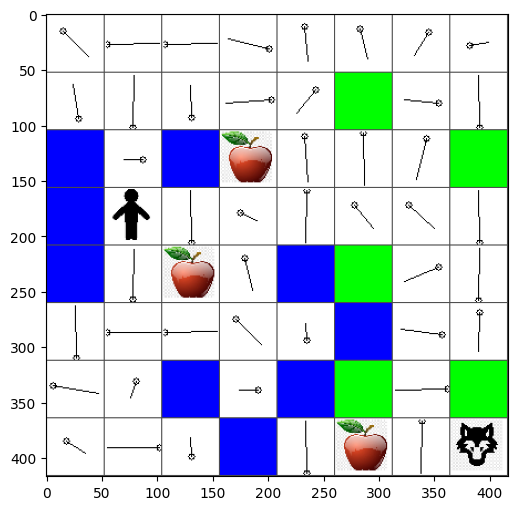

In [12]:
m.plot(Q)

### Check the Policy
Simply select the actions corresponding to the highest Q-Table value

In [13]:
def qpolicy_strict(m):
    x, y = m.human
    v = probs(Q[x, y])
    a = list(actions)[np.argmax(v)]
    return a

walk(m, qpolicy_strict)


2

### Navigation
A better navigation policy is the one that combines exploitation and exploration. In this policy, we will select each action with a certain probability, proportional to the values in the Q-Table. 

In [14]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


### Investigating the learning process

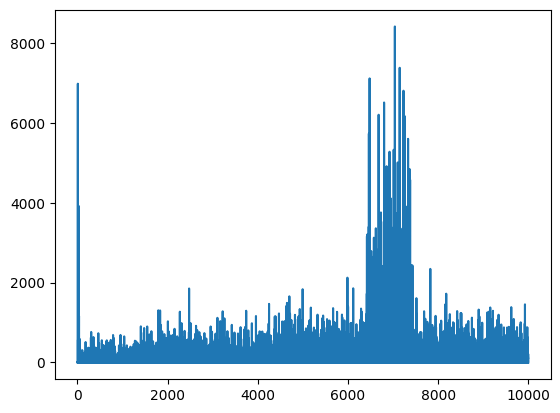

In [15]:
plt.plot(lpath)